In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sct
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import binom

### CSVファイルの読み込み

In [3]:
#CSVデータの読み込み
data = pd.read_csv("chap6_data1.csv",dtype={"y": int,"x":float, "f":"category"})
#data = pd.read_csv("chap6_data1.csv")

In [4]:
#先頭5件を表示
#Nは種子の数（8で固定）
#yは種子の生存数
#xは個体サイズ
#fは肥料の有無
data.head()

,N,y,x,f
0,8,1,9.76,C
1,8,6,10.48,C
2,8,5,10.83,C
3,8,6,10.94,C
4,8,1,9.37,C


In [5]:
data.describe()

,N,y,x
count,100.0,100.000000,100.000000
mean,8.0,5.080000,9.967200
std,0.0,2.743882,1.088954
min,8.0,0.000000,7.660000
25%,8.0,3.000000,9.337500
50%,8.0,6.000000,9.965000
75%,8.0,8.000000,10.770000
max,8.0,8.000000,12.440000


In [6]:
data.shape

(100, 4)

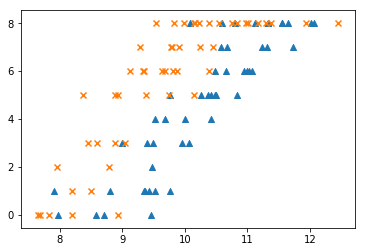

In [7]:
#fのデータの値に基づいてデータを分割する
c_data = data[data['f'] == 'C']
t_data = data[data['f'] == 'T']

#分割した各データをラベルとマーカーを指定して描画
plt.scatter(c_data.x, c_data.y, marker ='^', label = 'C')
plt.scatter(t_data.x, t_data.y, marker ='x', label = 'T')

### 二項分布の可視化

In [8]:
#二項分布の確率分布
#試行回数を1回から100回とする
#成功率を0.1, 0.5, 0.9の各場合における成功回数の確率分布を図示する

#xは成功回数
x = range(0, 100)
#pは成功率
p = 0.1
#nは試行回数
#xとは別に定義することができる
n = 100

y1 = binom.pmf(x, n, p)
y2 = binom.pmf(x, n, p=0.5)
y3 = binom.pmf(x, n, p=0.9)

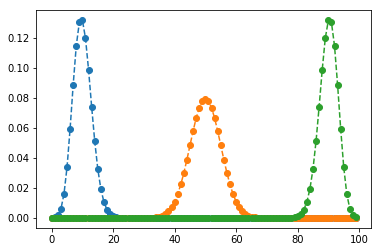

In [9]:
plt.plot(x, y1, "o--")
plt.plot(x, y2, "o--")
plt.plot(x, y3, "o--")

### 2項分布を用いた最尤推定の実施

#### ロジスティック関数

In [19]:
#ロジスティック関数の図示
#シグモイド関数はロジスティック関数の形式の一つ
#つまりシグモイド関数は狭義のロジスティック関数

#labmda関数を使えばわざわざdefの宣言は不要なので見通しがよくなる
#def sigmoid(x):
#    return 1 /(1+np.exp(-x))

sigmoid = lambda x: 1 / (1 + np.exp(-x))

x = np.arange(-6,6,0.1)
y = sigmoid(x)

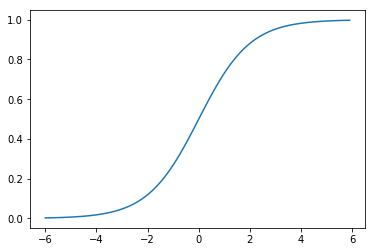

In [20]:
plt.plot(x,y)

#### ロジットリンク関数
* ロジスティック関数の逆関数がロジットリンク関数

In [21]:
#Binomialの場合は成功数と失敗数を~の前に記載する
model = smf.glm('y + I(N-y)~ x + f', data=data, family=sm.families.Binomial())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -133.11
Date:                Fri, 28 Feb 2020   Deviance:                       123.03
Time:                        11:33:02   Pearson chi2:                     109.
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.5361      1.414    -13.818      0.000     -22.307     -16.765
f[T.T]         2.0215      0.231      8.740      0.000       1.568       2.475
x              1.9524      0.139     14.059      0.000       1.680       2.225
==============================================================================
"""

In [23]:
result.params

Intercept   -19.536066
f[T.T]        2.021506
x             1.952406
dtype: float64

### 2項分布を用いたデータへのフィッティング
* リンク関数はロジスティック関数の逆関数のロジットリンク関数となる
* f(y) = beta1 + beta2 *x * beta3 * (C or T)
* ↑の形からわかるようにyの形状はロジットリンク関数の逆関数のロジスティック関数となる
* 定性的に説明するとロジットリンク関数はオッズ比(q_i/(1 - q_i))と一致する

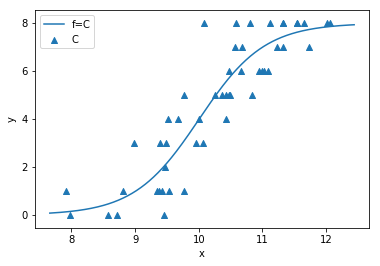

In [32]:
#推定値からプロット
#推定対象はbeta1 + beta2 *x * beta3 * (C or T)の3変数
#(C or T)は（0 or 1）として扱う

z = lambda beta1, beta2, beta3, x: beta1 + beta2 * x + beta3
x = np.arange(data['x'].min(), data['x'].max() + 0.01, 0.01)

logistic = lambda z: 1 / (1 + np.exp(-z))

#割と綺麗にフィッティングする
plt.plot(x, [logistic(z_i) * 8 for z_i in z(result.params['Intercept'], result.params['x'], 0, x)], label='f=C', color="tab:blue")
plt.scatter(c_data.x, c_data.y, marker ='^', label = 'C', color="tab:blue")
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

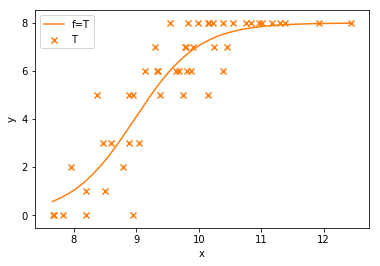

In [34]:
#同じく割と綺麗にフィッティングする
plt.plot(x, [logistic(z_i) * 8 for z_i in z(result.params['Intercept'], result.params['x'], result.params['f[T.T]'], x)], label='f=T', color="tab:orange")
plt.scatter(t_data.x, t_data.y, marker ='x', label = 'T', color="tab:orange")
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### ロジスティック回帰のモデル選択

In [37]:
#'y + I(N-y)~ x + f'が一番AICが低いことがわかる
families = ['y + I(N-y)~ x + f', 'y + I(N-y)~ x', 'y + I(N-y)~ f', 'y + I(N-y)~ 1']

for family in families:
    model = smf.glm(family, data=data, family=sm.families.Binomial())
    result = model.fit()
    print(result.aic)

272.21112928522336
364.34544328371595
637.7597534566678
644.4093416623778


### 交互作用項の入った線形予測子

In [39]:
#familyにおいてx*fはx:fとして表記する
family = 'y + I(N-y)~ x + f + x:f'

model = smf.glm(family, data=data, family=sm.families.Binomial())
result = model.fit()
print(result.aic)

273.6105967259739


### ガンマ関数

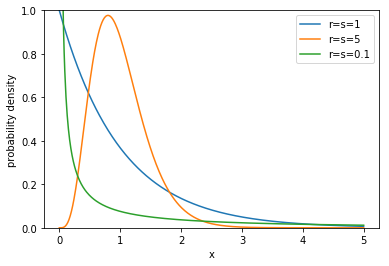

In [43]:
#ガンマ分布の確率密度関数
#ガンマ分布は連続値なので「確率分布」ではなく「確率密度」になることに注意
#確率分布関数も確率密度関数も横軸がy軸に相当する
#ガンマ関数の確率変数は必ず正になる
#正規分布の確率変数は正とは限らない
from scipy.stats import gamma

x = np.arange(0.00, 5.01, 0.01)

plt.plot(x, [gamma.pdf(x_i, a=1, scale=1/1) for x_i in x], label='r=s=1')
plt.plot(x, [gamma.pdf(x_i, a=5, scale=1/5) for x_i in x], label='r=s=5')
plt.plot(x, [gamma.pdf(x_i, a=0.1, scale=1/0.1) for x_i in x], label='r=s=0.1')
plt.ylim([0.0, 1.0])
plt.legend()
plt.xlabel('x')
plt.ylabel('probability density')
plt.show()

In [45]:
#CSVデータの読み込み
data = pd.read_csv("chap6_data2.csv")
data.head()

,Unnamed: 0,x,y
0,1,0.001000,0.000887
1,2,0.017306,0.023465
2,3,0.033612,0.069876
3,4,0.049918,0.034340
4,5,0.066224,0.026520


Text(0, 0.5, 'y')

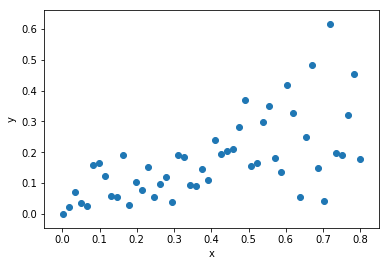

In [47]:
#リンク関数は指数関数
#y軸は重さなので必ず正⇛よって誤差構造はガンマ関数
plt.scatter(data.x,data.y)
plt.xlabel("x")
plt.ylabel("y")

In [71]:
#自由度は2のモデル
#y = A * x^bと仮定
#log y = logA + b * log(x)
#yは正確には平均であり、平均周りの散らばりがガンマ分布に従うと仮定した
model = smf.glm('y ~ np.log(x)' ,data=data, family=sm.families.Gamma(link=sm.families.links.log))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:                            GLM   Df Residuals:                       48
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                         0.32508
Method:                          IRLS   Log-Likelihood:                 58.471
Date:                Fri, 28 Feb 2020   Deviance:                       17.251
Time:                        13:08:05   Pearson chi2:                     15.6
No. Iterations:                    18   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0403      0.119     -8.759      0.000      -1.273      -0.808
np.log(x)      0.6832      0.068      9.992      0.000       0.549       0.817
==============================================================================
"""

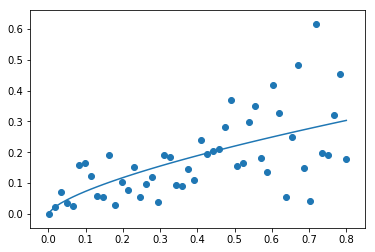

In [73]:
A = np.exp(result.params['Intercept'])
y = lambda x: A * np.exp(result.params['np.log(x)'] * np.log(x))

plt.scatter(data.x,data.y)
plt.plot(data.x, [y(x) for x in data.x])
plt.show()